In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
import wandb

In [5]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: eraldoluis (use `wandb login --relogin` to force relogin)


True

In [67]:
api = wandb.Api()
sweep_ids = ["1qcd2x0p", "dwqldmag", "s3jg6oju"]
sweeps = [api.sweep(f"eraldoluis/WeightedCRF/{sweep_id}") for sweep_id in sweep_ids]

In [68]:
runs = [run for sweep in sweeps for run in sweep.runs]
# run = next(runs)
# next(run.scan_history(keys=["model.label_weights.O", "validation/macro-fscore"]))
len(runs)

49

In [69]:
import pandas as pd 
# import wandb
# api = wandb.Api()

# # Project is specified by <entity/project-name>
# runs = api.runs("eraldoluis/WeightedCRF")

values = []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    val = {k: v for k, v in run.summary._json_dict.items() if "validation/macro" in k}

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    val.update({
        k: v for k, v in run.config.items() 
            if not k.startswith('_') and "label_weights" in k})

    # .name is the human-readable name of the run.
    val["name"] = run.name

    values.append(val)

runs_df = pd.DataFrame(values)

In [70]:
runs_df.head(5)

,validation/macro-recall,validation/macro-fscore,validation/macro-precision,model.label_weights,name
0,0.870169,0.869368,0.869571,{'MISC': 1.2},crimson-sweep-20
1,0.834931,0.829785,0.845316,{'MISC': 1.15},wandering-sweep-19
2,0.863239,0.869199,0.881648,{'MISC': 1.1},hearty-sweep-18
3,0.838979,0.845236,0.879502,{'MISC': 1.05},glowing-sweep-17
4,0.857162,0.861782,0.873831,{'LOC': 1.2},stellar-sweep-16


In [77]:
tags = ["O", "PER", "LOC", "ORG", "MISC"]
base_dict = {k: 1.0 for k in tags}
def transf(w):
    new_d = dict(base_dict)
    new_d.update(w)
    new_d = {f"label_weight_{k}": v for k, v in new_d.items()}
    return pd.Series(new_d)

df_runs_weights = pd.concat([runs_df, runs_df["model.label_weights"].apply(transf)], axis=1)

In [79]:
df_runs_weights.sample(5)

,validation/macro-recall,validation/macro-fscore,validation/macro-precision,model.label_weights,name,label_weight_O,label_weight_PER,label_weight_LOC,label_weight_ORG,label_weight_MISC
46,0.866844,0.867902,0.882498,{'O': 1},hearty-sweep-3,1.0,1.0,1.0,1.0,1.0
38,0.829728,0.849750,0.883209,{'O': 0.9},devout-sweep-11,0.9,1.0,1.0,1.0,1.0
21,0.867213,0.849523,0.850099,{'LOC': 1},distinctive-sweep-4,1.0,1.0,1.0,1.0,1.0
22,0.860938,0.853911,0.858036,{'ORG': 1},pleasant-sweep-3,1.0,1.0,1.0,1.0,1.0
7,0.826453,0.798697,0.804284,{'ORG': 1.2},drawn-sweep-12,1.0,1.0,1.0,1.2,1.0


In [81]:
cols = [f"label_weight_{tag}" for tag in tags]
sel = [df_runs_weights[col] == 1.0 for col in cols]

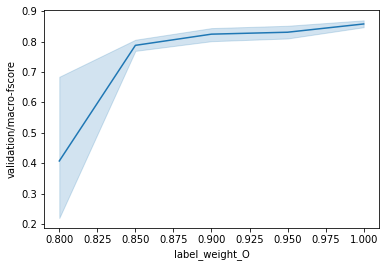

In [88]:
import numpy as np
def plot_one(idx):
    sel_ = [s for i, s in enumerate(sel) if i != idx]
    sel_res = sel_[0]
    for s in sel_[1:]:
        sel_res = (sel_res & s)
    sns.lineplot(data=df_runs_weights[sel_res], x=cols[idx], y="validation/macro-fscore")

plot_one(0)

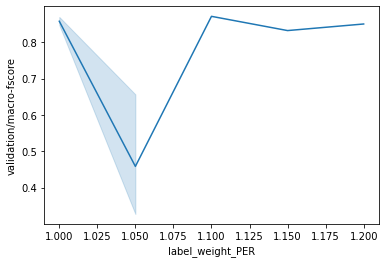

In [89]:
plot_one(1)

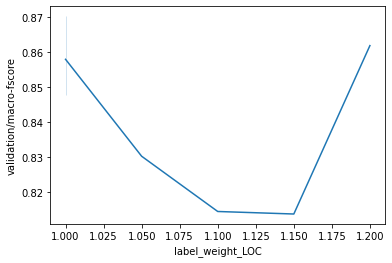

In [90]:
plot_one(2)

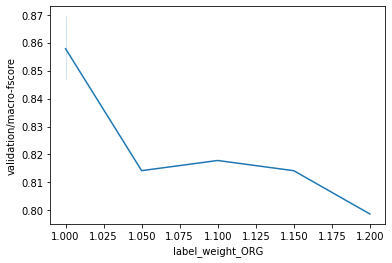

In [91]:
plot_one(3)

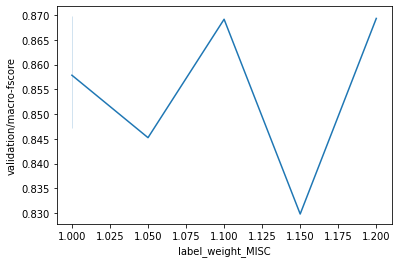

In [92]:
plot_one(4)